In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv('/weather_data.csv')
df.head()

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
0,San Diego,2024-01-14 21:12:46,10.683001,41.195754,4.020119,8.233540
1,San Diego,2024-05-17 15:22:10,8.734140,58.319107,9.111623,27.715161
2,San Diego,2024-05-11 09:30:59,11.632436,38.820175,4.607511,28.732951
3,Philadelphia,2024-02-26 17:32:39,-8.628976,54.074474,3.183720,26.367303
4,San Antonio,2024-04-29 13:23:51,39.808213,72.899908,9.598282,29.898622


In [3]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'])

In [4]:
# Ordenar por ciudad y tiempo
df = df.sort_values(by=['Location', 'Date_Time'])

In [5]:
df_city = df[df['Location'] == 'San Diego'].reset_index(drop=True)


In [6]:
df_city.head()

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
0,San Diego,2024-01-01 00:00:31,-8.090262,81.472454,5.435076,7.609853
1,San Diego,2024-01-01 00:01:10,-4.535508,81.416645,1.715090,10.192158
2,San Diego,2024-01-01 00:01:47,11.480192,80.943070,8.375043,23.057915
3,San Diego,2024-01-01 00:02:40,-2.776906,69.075143,4.057751,14.997110
4,San Diego,2024-01-01 00:02:47,28.771493,34.259600,4.018268,14.299193


In [ ]:
#Verificar datos faltantes
print("Valores faltantes por columna:")
print(df_city.isnull().sum())

Valores faltantes por columna:
Location            0
Date_Time           0
Temperature_C       0
Humidity_pct        0
Precipitation_mm    0
Wind_Speed_kmh      0
dtype: int64


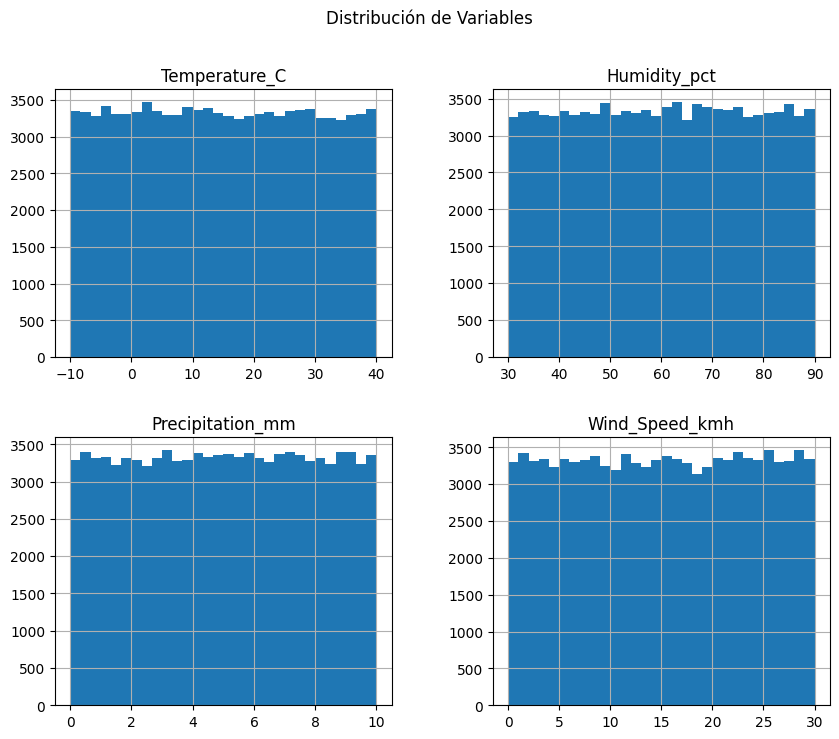

In [8]:
df_city[['Temperature_C', 'Humidity_pct', 'Precipitation_mm', 'Wind_Speed_kmh']].hist(bins=30, figsize=(10, 8))
plt.suptitle('Distribución de Variables')
plt.show()


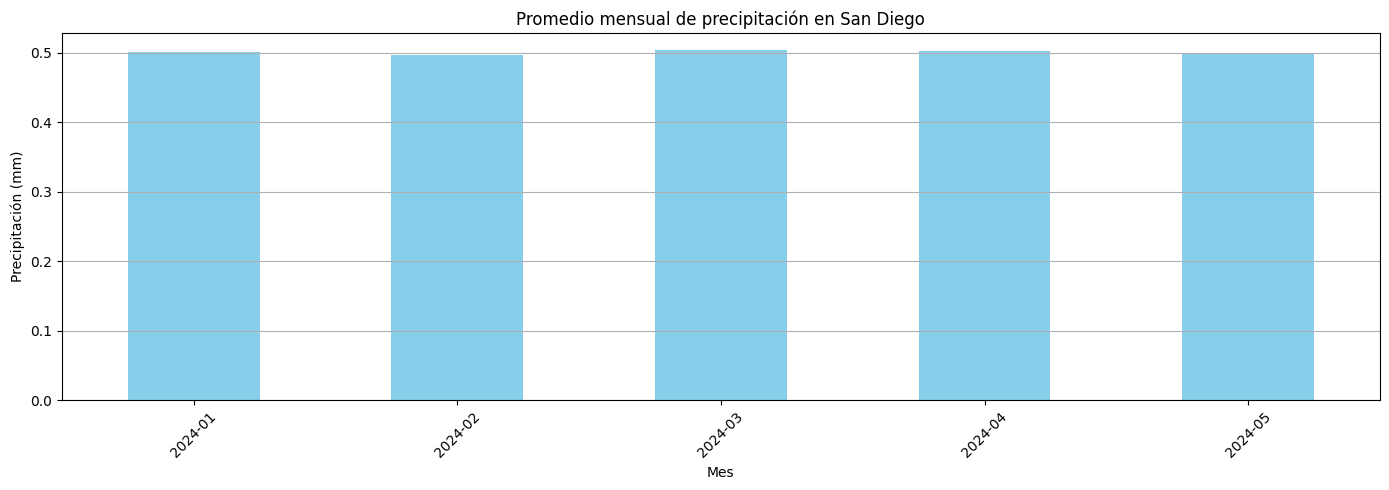

In [28]:
df_city['Month'] = df_city['Date_Time'].dt.to_period('M')
monthly_precip = df_city.groupby('Month')['Precipitation_mm'].mean()

monthly_precip.plot(kind='bar', figsize=(14, 5), color='skyblue')
plt.title('Promedio mensual de precipitación en San Diego')
plt.xlabel('Mes')
plt.ylabel('Precipitación (mm)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

<ipython-input-30-0e1e4bb01e2c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Hour', y='Temperature_C', data=df_city, palette='coolwarm')


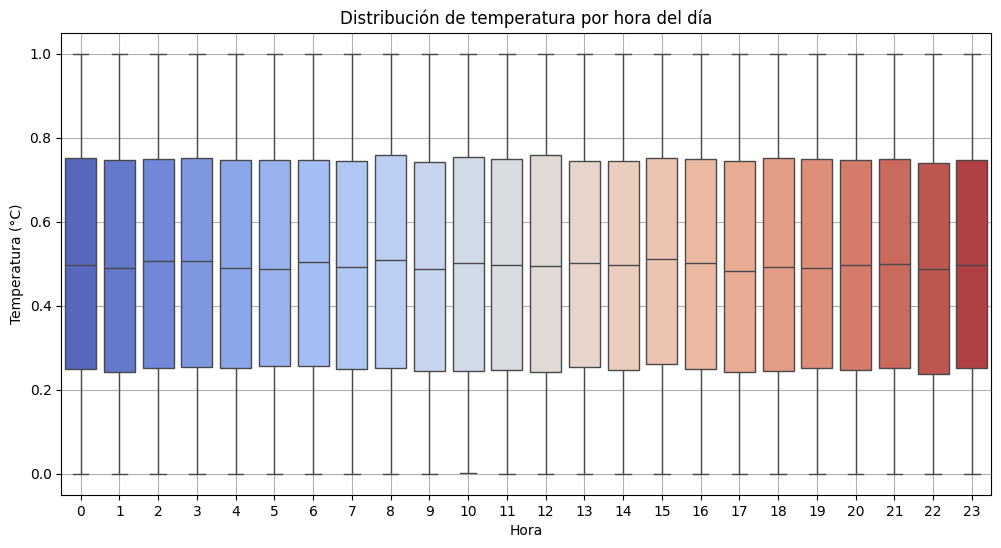

In [30]:
df_city['Hour'] = df_city['Date_Time'].dt.hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='Hour', y='Temperature_C', data=df_city, palette='coolwarm')
plt.title('Distribución de temperatura por hora del día')
plt.xlabel('Hora')
plt.ylabel('Temperatura (°C)')
plt.grid(True)
plt.show()

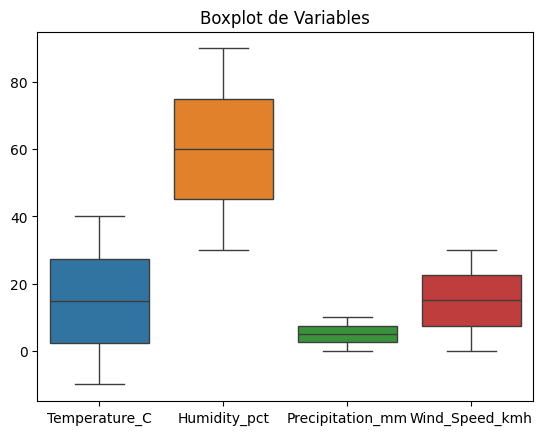

In [9]:
sns.boxplot(data=df_city[['Temperature_C', 'Humidity_pct', 'Precipitation_mm', 'Wind_Speed_kmh']])
plt.title('Boxplot de Variables')
plt.show()

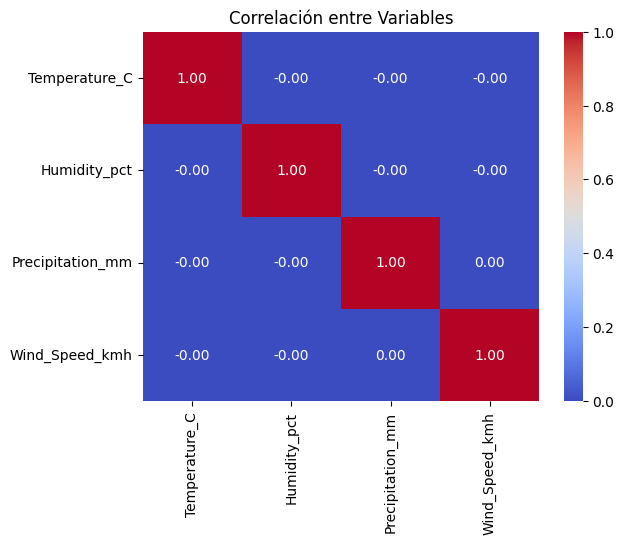

In [10]:
correlation = df_city[['Temperature_C', 'Humidity_pct', 'Precipitation_mm', 'Wind_Speed_kmh']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlación entre Variables')
plt.show()

In [ ]:
#Variables a normalizar
features = ['Temperature_C', 'Humidity_pct', 'Precipitation_mm', 'Wind_Speed_kmh']

scaler = MinMaxScaler()

#Normalizamos las columnas seleccionadas
df_city[features] = scaler.fit_transform(df_city[features])

df_city.head()

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
0,San Diego,2024-01-01 00:00:31,0.038195,0.857886,0.543519,0.253647
1,San Diego,2024-01-01 00:01:10,0.109290,0.856956,0.171507,0.339726
2,San Diego,2024-01-01 00:01:47,0.429606,0.849063,0.837527,0.768594
3,San Diego,2024-01-01 00:02:40,0.144463,0.651256,0.405781,0.499895
4,San Diego,2024-01-01 00:02:47,0.775435,0.070974,0.401833,0.476630


In [ ]:
#Función para crear las secuencias
def create_sequences(data, seq_length=24):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        # Tomar las 'seq_length' filas de entrada (features)
        sequences.append(data[i:i+seq_length][features].values)
        # La etiqueta es el valor siguiente (predecir el siguiente valor)
        labels.append(data.iloc[i+seq_length][features].values)

    return np.array(sequences), np.array(labels)

X, y = create_sequences(df_city, seq_length=24)

print(f"Tamaño de X: {X.shape}")
print(f"Tamaño de y: {y.shape}")

Tamaño de X: (99750, 24, 4)
Tamaño de y: (99750, 4)


In [ ]:
#Construir el modelo
model = Sequential()

#capa LSTM
model.add(LSTM(units=64, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences=False))

#para evitar sobreajuste
model.add(Dropout(0.2))

#capa densa de salida
model.add(Dense(units=4))  # Predicción para 4 variables

model.compile(optimizer=Adam(), loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,924 (70.02 KB)

 Trainable params: 17,924 (70.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")

Tamaño de X_train: (79800, 24, 4)
Tamaño de X_test: (19950, 24, 4)


In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [16]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 0.0938 - val_loss: 0.0837
Epoch 2/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - loss: 0.0842 - val_loss: 0.0836
Epoch 3/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - loss: 0.0840 - val_loss: 0.0835
Epoch 4/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 0.0833 - val_loss: 0.0835
Epoch 5/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - loss: 0.0833 - val_loss: 0.0834
Epoch 6/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - loss: 0.0834 - val_loss: 0.0834
Epoch 7/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - loss: 0.0832 - val_loss: 0.0834
Epoch 8/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - loss: 0.0834 - val_loss: 0.0835
Epoch 9/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 79s 17ms/step - loss: 0.0835 - val_loss: 0.0834
Epoch 10/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - loss: 0.0837 - val_loss: 0.0834


In [17]:
test_loss = model.evaluate(X_test, y_test)
print(f'Pérdida en el conjunto de prueba: {test_loss}')

624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0834
Pérdida en el conjunto de prueba: 0.08342503011226654


In [18]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


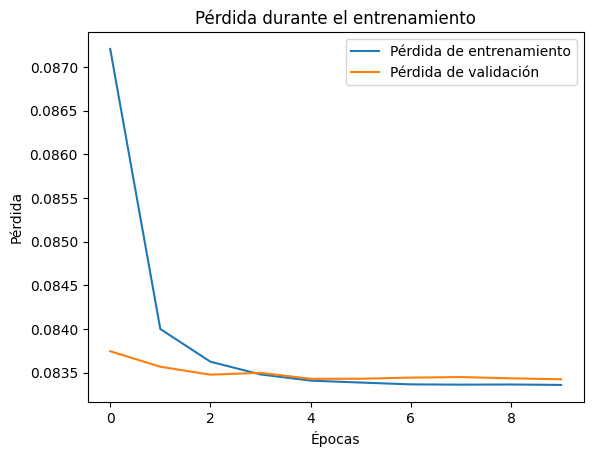

In [19]:
# Graficar la pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


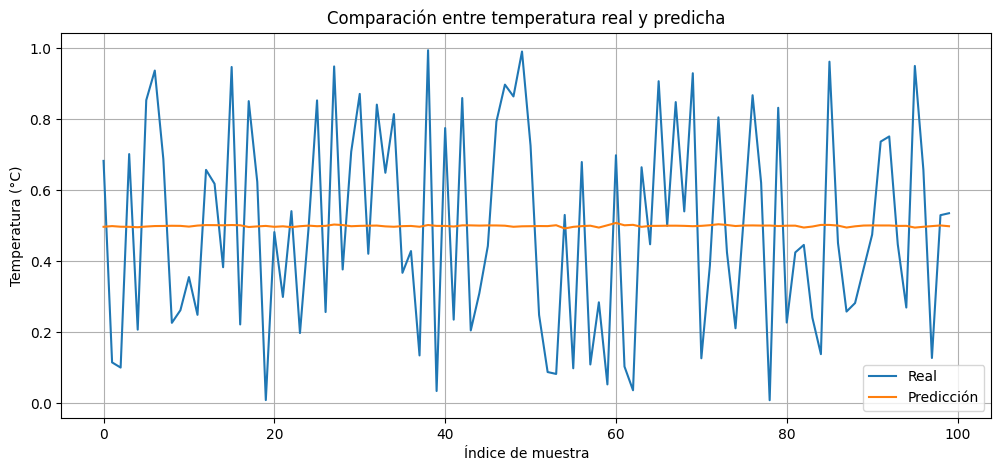

In [ ]:
#hacer predicciones
y_pred = model.predict(X_test)

#seleccionar la variable temperatura 
true_temp = y_test[:, 0]
pred_temp = y_pred[:, 0]

#Graficar los primeros 100 valores
plt.figure(figsize=(12, 5))
plt.plot(true_temp[:100], label='Real')
plt.plot(pred_temp[:100], label='Predicción')
plt.title('Comparación entre temperatura real y predicha')
plt.xlabel('Índice de muestra')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()

624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


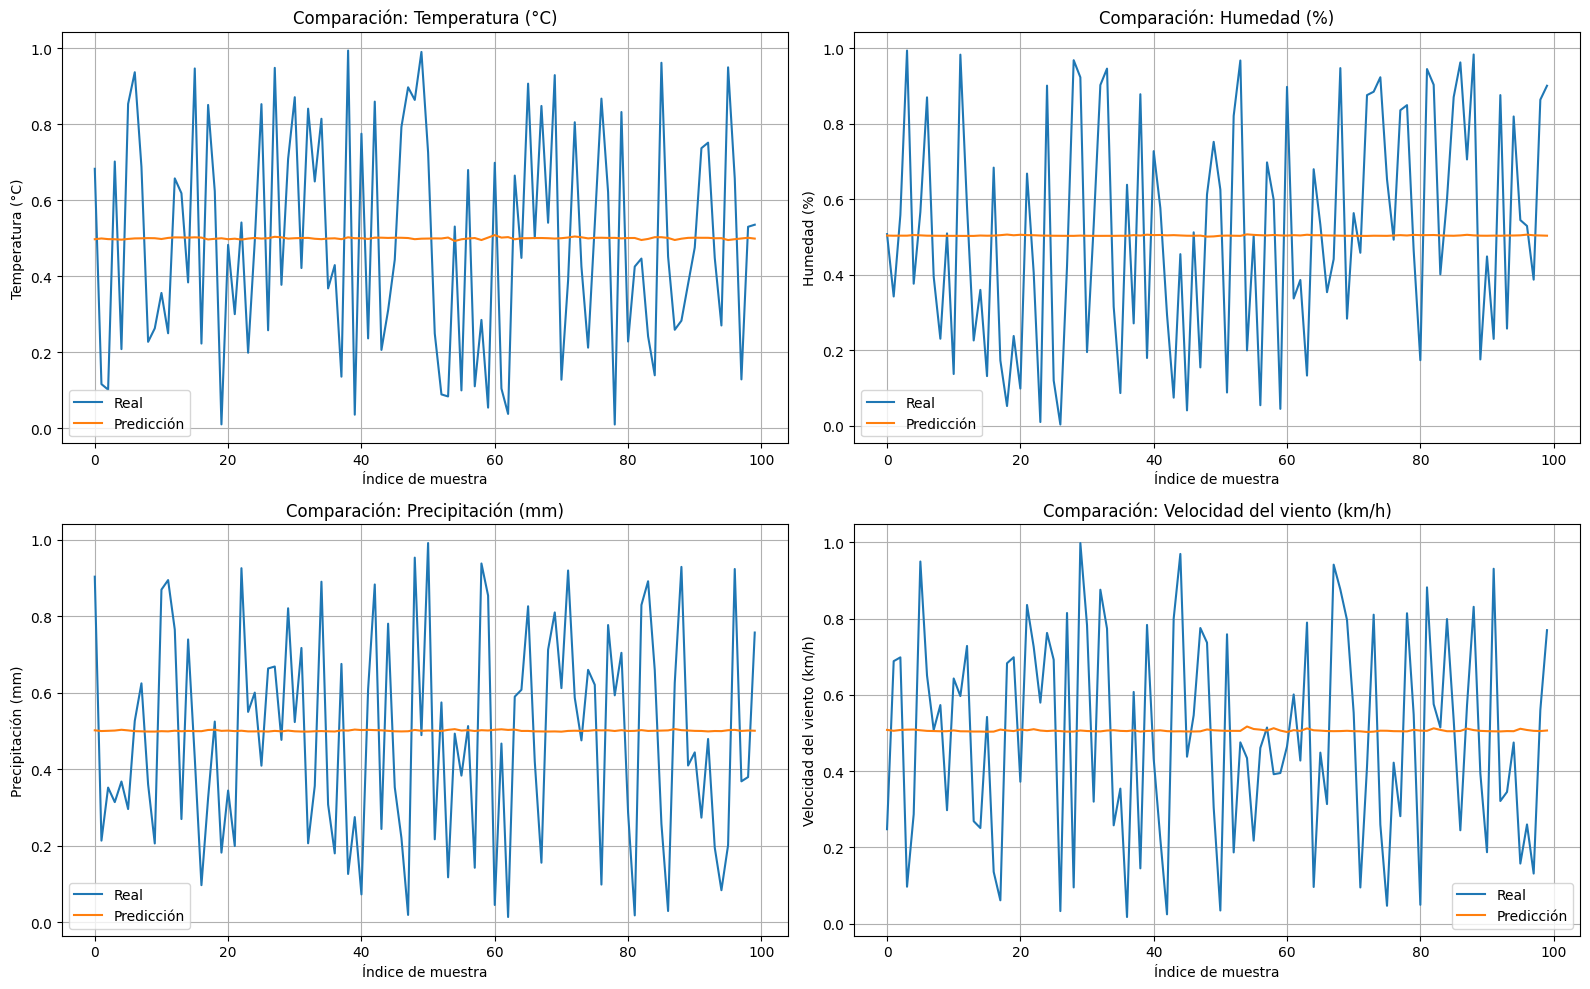

In [ ]:

y_pred = model.predict(X_test)

variables = ['Temperatura (°C)', 'Humedad (%)', 'Precipitación (mm)', 'Velocidad del viento (km/h)']

#Graficar las primeras 100 muestras para cada variable
plt.figure(figsize=(16, 10))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(y_test[:, i][:100], label='Real')
    plt.plot(y_pred[:, i][:100], label='Predicción')
    plt.title(f'Comparación: {variables[i]}')
    plt.xlabel('Índice de muestra')
    plt.ylabel(variables[i])
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

y_test_np = y_test.reshape(-1, 4)
y_pred_np = y_pred.reshape(-1, 4)

mae = mean_absolute_error(y_test_np, y_pred_np)
mse = mean_squared_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.2501
Mean Squared Error (MSE): 0.0834
R² Score: -0.0001


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2494/2494 ━━━━━━━━━━━━━━━━━━━━ 46s 17ms/step - loss: 0.0916 - val_loss: 0.0835
Epoch 2/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 78s 16ms/step - loss: 0.0844 - val_loss: 0.0836
Epoch 3/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 0.0836 - val_loss: 0.0837
Epoch 4/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0836 - val_loss: 0.0835
Epoch 5/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - loss: 0.0834 - val_loss: 0.0835
Epoch 6/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - loss: 0.0834 - val_loss: 0.0834
Epoch 7/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - loss: 0.0836 - val_loss: 0.0834
Epoch 8/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.0835 - val_loss: 0.0836
Epoch 9/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.0835 - val_loss: 0.0834
Epoch 10/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - loss: 0.0834 - val_loss: 0.0835
624/624 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0834
Pérdida en el conjunto de prueba: 0.08345771580934525


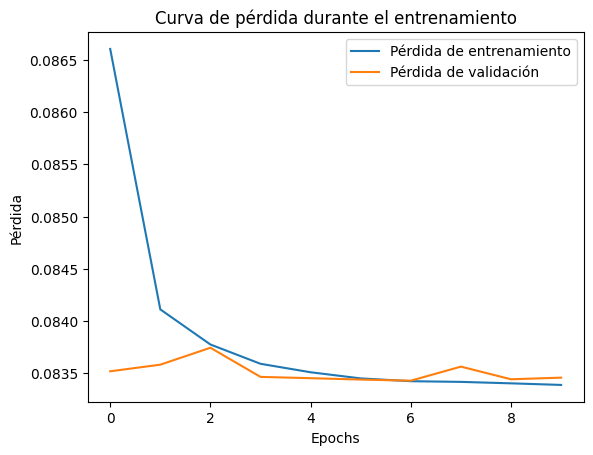

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dropout(0.2))  # Dropout con tasa del 20%
model.add(Dense(4))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

test_loss = model.evaluate(X_test_scaled, y_test)
print(f"Pérdida en el conjunto de prueba: {test_loss}")

plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curva de pérdida durante el entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


Epoch 1/20
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 80s 30ms/step - loss: 0.0899 - val_loss: 0.0844
Epoch 2/20
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 77s 31ms/step - loss: 0.0841 - val_loss: 0.0835
Epoch 3/20
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 83s 31ms/step - loss: 0.0838 - val_loss: 0.0834
Epoch 4/20
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 84s 32ms/step - loss: 0.0836 - val_loss: 0.0836
Epoch 5/20
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 81s 32ms/step - loss: 0.0836 - val_loss: 0.0835
Epoch 6/20
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 76s 30ms/step - loss: 0.0836 - val_loss: 0.0834
Epoch 7/20
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 73s 29ms/step - loss: 0.0833 - val_loss: 0.0834
Epoch 8/20
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 79s 32ms/step - loss: 0.0835 - val_loss: 0.0835
Epoch 9/20
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 75s 30ms/step - loss: 0.0834 - val_loss: 0.0834
Epoch 10/20
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 81s 30ms/step - loss: 0.0837 - val_loss: 0.0834
Epoch 11/20
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 90s 33ms/step - loss: 0.0836 - val_loss: 0.0835
Epoch 12

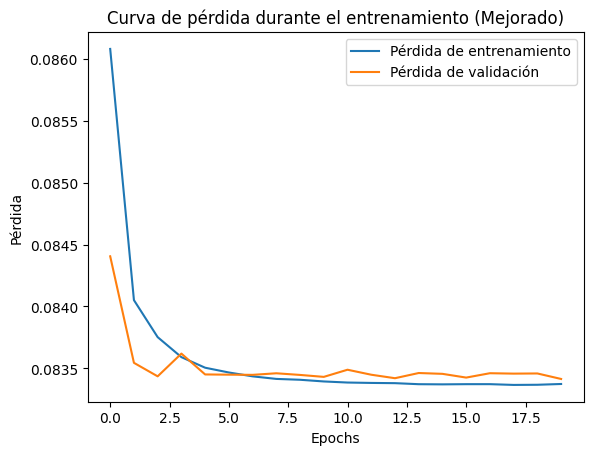

In [ ]:
#modelo mejorado con más capas LSTM y Dropout ajustado
model = Sequential()

#primera capa LSTM
model.add(LSTM(64, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dropout(0.2))

#segunda capa LSTM
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))

#capa densa de salida
model.add(Dense(4))

#compilación del modelo
model.compile(optimizer='adam', loss='mean_squared_error')

#entrenar el modelo mejorado
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test))

#evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(X_test_scaled, y_test)
print(f"Pérdida en el conjunto de prueba: {test_loss}")

plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curva de pérdida durante el entrenamiento (Mejorado)')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


624/624 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0833
Pérdida en el conjunto de prueba: 0.0834149643778801


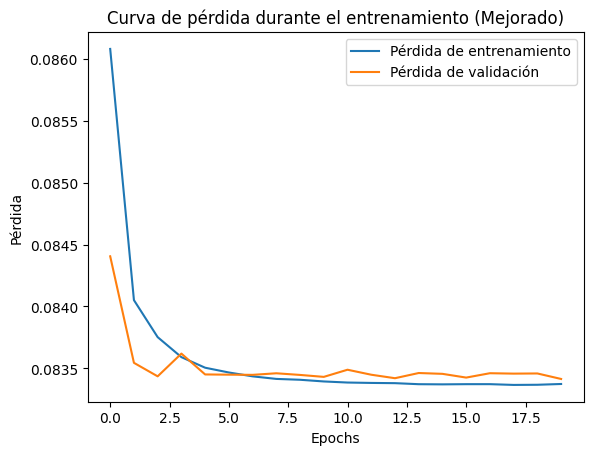

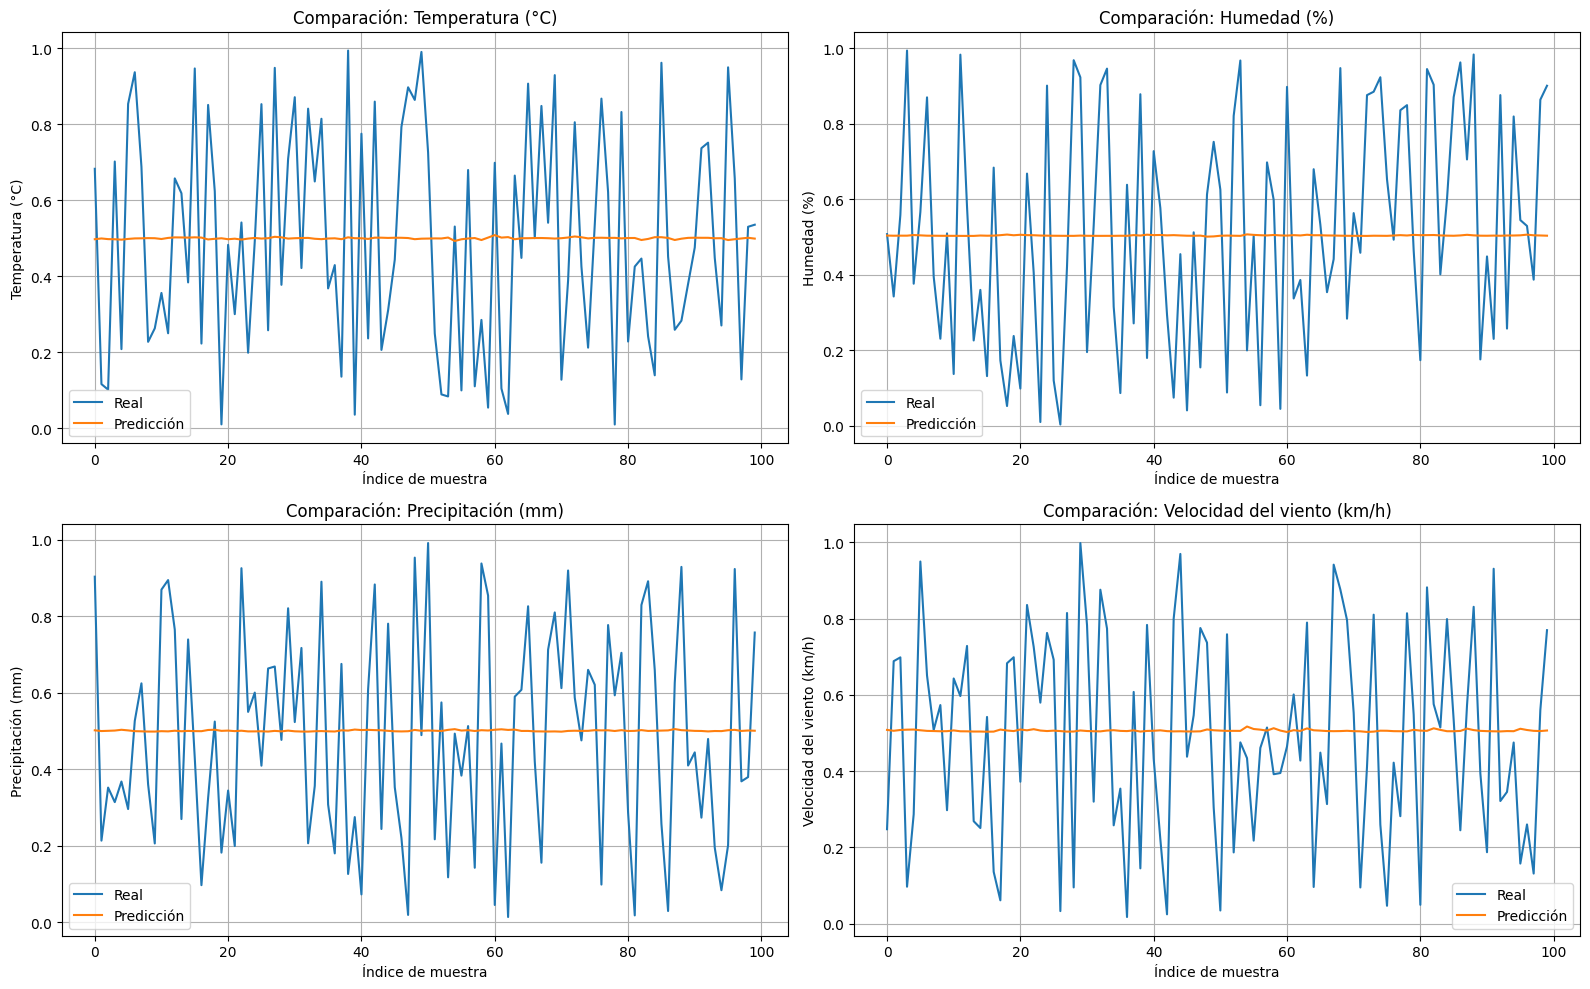


Métricas para Temperatura (°C):
  Mean Absolute Error (MAE): 0.2510
  Mean Squared Error (MSE): 0.0839
  R² Score: -0.0001

Métricas para Humedad (%):
  Mean Absolute Error (MAE): 0.2491
  Mean Squared Error (MSE): 0.0829
  R² Score: -0.0000

Métricas para Precipitación (mm):
  Mean Absolute Error (MAE): 0.2506
  Mean Squared Error (MSE): 0.0836
  R² Score: 0.0000

Métricas para Velocidad del viento (km/h):
  Mean Absolute Error (MAE): 0.2498
  Mean Squared Error (MSE): 0.0833
  R² Score: -0.0004

Métricas globales:
  Mean Absolute Error (MAE): 0.2501
  Mean Squared Error (MSE): 0.0834
  R² Score: -0.0001


In [ ]:

test_loss = model.evaluate(X_test_scaled, y_test)
print(f"Pérdida en el conjunto de prueba: {test_loss}")

plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curva de pérdida durante el entrenamiento (Mejorado)')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar las predicciones en escalas originales
y_test_original = scaler.inverse_transform(y_test)  # Invertimos el escalado de las etiquetas verdaderas
y_pred_original = scaler.inverse_transform(y_pred)  # Invertimos el escalado de las predicciones

variables = ['Temperatura (°C)', 'Humedad (%)', 'Precipitación (mm)', 'Velocidad del viento (km/h)']


plt.figure(figsize=(16, 10))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(y_test_original[:, i][:100], label='Real')
    plt.plot(y_pred_original[:, i][:100], label='Predicción')
    plt.title(f'Comparación: {variables[i]}')
    plt.xlabel('Índice de muestra')
    plt.ylabel(variables[i])
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

#Cálculo de métricas por variable
for i, var in enumerate(variables):
    mae_var = mean_absolute_error(y_test_original[:, i], y_pred_original[:, i])
    mse_var = mean_squared_error(y_test_original[:, i], y_pred_original[:, i])
    r2_var = r2_score(y_test_original[:, i], y_pred_original[:, i])

    print(f"\nMétricas para {var}:")
    print(f"  Mean Absolute Error (MAE): {mae_var:.4f}")
    print(f"  Mean Squared Error (MSE): {mse_var:.4f}")
    print(f"  R² Score: {r2_var:.4f}")

#Cálculo de las métricas globales
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f"\nMétricas globales:")
print(f"  Mean Absolute Error (MAE): {mae:.4f}")
print(f"  Mean Squared Error (MSE): {mse:.4f}")
print(f"  R² Score: {r2:.4f}")
